In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = read_csv('df_train_callvolume (1).csv', usecols=[1])

In [3]:
#Convert pandas dataframe to numpy array
dataset = df.values
dataset = dataset.astype('float32') #COnvert values to float

In [4]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) 
dataset = scaler.fit_transform(dataset)

In [5]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [6]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 96  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [7]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (23029, 96)
Shape of test set: (11817, 96)


In [8]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()
print('Train...')


Single LSTM with hidden Dense...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41216     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 43,329
Trainable params: 43,329
Non-trainable params: 0
_________________________________________________________________
Train...


In [9]:
model.fit(trainX, trainY, validation_data=(testX, testY), 
          verbose=2, epochs=100)

Epoch 1/100
720/720 - 4s - loss: 0.0079 - val_loss: 0.0066 - 4s/epoch - 5ms/step
Epoch 2/100
720/720 - 2s - loss: 0.0070 - val_loss: 0.0062 - 2s/epoch - 3ms/step
Epoch 3/100
720/720 - 2s - loss: 0.0067 - val_loss: 0.0062 - 2s/epoch - 2ms/step
Epoch 4/100
720/720 - 2s - loss: 0.0067 - val_loss: 0.0062 - 2s/epoch - 3ms/step
Epoch 5/100
720/720 - 2s - loss: 0.0066 - val_loss: 0.0062 - 2s/epoch - 3ms/step
Epoch 6/100
720/720 - 2s - loss: 0.0066 - val_loss: 0.0061 - 2s/epoch - 2ms/step
Epoch 7/100
720/720 - 2s - loss: 0.0065 - val_loss: 0.0060 - 2s/epoch - 2ms/step
Epoch 8/100
720/720 - 2s - loss: 0.0066 - val_loss: 0.0060 - 2s/epoch - 2ms/step
Epoch 9/100
720/720 - 2s - loss: 0.0065 - val_loss: 0.0061 - 2s/epoch - 3ms/step
Epoch 10/100
720/720 - 2s - loss: 0.0065 - val_loss: 0.0063 - 2s/epoch - 3ms/step
Epoch 11/100
720/720 - 2s - loss: 0.0065 - val_loss: 0.0060 - 2s/epoch - 3ms/step
Epoch 12/100
720/720 - 2s - loss: 0.0064 - val_loss: 0.0060 - 2s/epoch - 2ms/step
Epoch 13/100
720/720 - 2s

In [10]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [12]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [13]:
# calculate mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MSE' % (testScore))

Train Score: 2.41 MSE
Test Score: 2.67 MSE


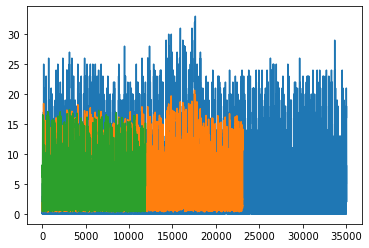

In [14]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredict)
plt.plot(testPredict)
plt.show()